In [194]:
# import sobol seq
# !pip install sobol_seq
import sobol_seq

# the following command line produces sound and is used after cells that 
# require more time to execute :
import IPython.display # to display .png
#    Audio(wave, rate=10000, autoplay=True)
from IPython.display import Audio
import numpy as np
wave = np.sin(1.5*np.pi*400*np.arange(10000)/10000) 

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms # 
import torchvision.datasets.mnist as mnist  # to import data

# we use torch.cuda.Event(enable_timing=True) to measure time
# from timeit import default_timer as timer
# import time

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import collections           # for ordered_dictionnary
import torch.nn.init as init # to initialize model

import copy                  # for copy.deepcopy( ... )

import matplotlib.pyplot as plt # to show pictures

from matplotlib.pyplot import figure # to plot
import datetime                      # to include date in log file name

import math # for ceil ()

import collections
import torch.nn.init as init

# Assigment 1, part 2

## import data

In [3]:
transform1 = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform2 = transforms.Compose( [transforms.ToTensor(), transforms.Normalize( (0.1307,), (0.3081,)) ])
transform3 = transforms.Compose( [transforms.ToTensor()] )
dl_path  = "./data_mnist"

trainset = mnist.MNIST( root = dl_path, train=True , download=True, transform = transform3 )
testset  = mnist.MNIST( root = dl_path, train=False, download=True, transform = transform3 )

display some samples

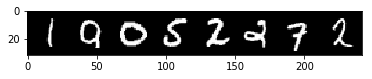

    1     9     0     5     2     2     7     2
img size =  torch.Size([8, 1, 28, 28]) label size =  torch.Size([8])
tensor(1.) tensor(0.)


In [4]:
nb_sample = 8

trainloader = torch.utils.data.DataLoader(trainset, batch_size = nb_sample, shuffle=True , num_workers=2)
testloader  = torch.utils.data.DataLoader(testset , batch_size = nb_sample, shuffle=False, num_workers=2)

# functions to show an image

def imshow(img):
    # img = ( img + 0.43 ) / 3.3    # to be in the interval [0,1]
    npimg = img.numpy()
    npimg = (255*npimg).astype(np.uint8) # to be a int in (0,...,255)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(nb_sample)))
print( "img size = " , images.size() , "label size = " , labels.size() )
print( images[0].max() ,images[0].min() )

print size of train-test dataset

In [5]:
train_dataset_size = trainset.__len__()
valid_dataset_size  = testset.__len__()

print( train_dataset_size )
print( valid_dataset_size )

60000
10000


set the device to cuda if possible

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Define some modules

### the MPL

In [7]:
class MLP(nn.Module):
    """
    MLP with 2 hidden layer
    """
    def __init__(self, h1=620,h2=620 ):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, h1)
        self.fc2 = nn.Linear(h1 , h2)
        self.fc3 = nn.Linear(h2 , 10)

    def forward(self, x):
        x = x.view( x.size()[0] , -1 )
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
class DeepMLP(nn.Module):
    """
    deep MLP with 6 hidden layer
    """
    def __init__(self, h=[512,512,256,128,128,128,10]):
        super(DeepMLP, self).__init__()
        self.lin = nn.Sequential(
            nn.Linear(1*28*28, h[0]),
            nn.ReLU(),
            nn.Linear(h[0], h[1]),
            nn.ReLU(),
            nn.Linear(h[1], h[2]),
            nn.ReLU(),
            nn.Linear(h[2], h[3]),
            nn.ReLU(),
            nn.Linear(h[3], h[4]),
            nn.ReLU(),
            nn.Linear(h[4], h[5]),
            nn.ReLU(),
            nn.Linear(h[5], h[6])
        )

    def forward(self, x):
        x = x.view( x.size()[0] , -1 )
        x = self.lin(x)
        return x

### The CNN

architecture taken from :
    https://github.com/MaximumEntropy/welcome_tutorials/tree/pytorch/pytorch

In [13]:
class CNNClassifier(nn.Module):
    """
    Convnet Classifier2, 3 conv layer, 2 fully connected layer
    """
    def __init__(self, kernel_sz1=11 , kernel_sz2=11, regression = 768, sigmoid=True ):
        
        self.sigmoid = sigmoid
        if kernel_sz1 % 2 == 0 or kernel_sz2 % 2 == 0 :
            raise ValueError("kernel size must be odd")
        pad1 = kernel_sz1 // 2 
        pad2 = kernel_sz2 // 2 
        
        super(CNNClassifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1, input size = 28^2
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=( kernel_sz1 , kernel_sz1 ), padding=pad1 ),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 28^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=( kernel_sz2 , kernel_sz2), padding=pad2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 14^2, output size 4^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=( 3 , 3 ), padding = 0, stride = 3),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),     
        )
        
        # Regression
        self.clf1 = nn.Linear(4*4*64, regression)
        self.clf2 = nn.Linear(regression, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0],-1)
        if self.sigmoid :
            x = torch.tanh(x)
        x = F.relu(self.clf1(x))
        x = self.clf2(x)
        return x

In [ ]:
class CNNClassifier3(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(CNNClassifier3, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1, input size = 28^2
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 14^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 7^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4, input size = 3^2, output size = 1^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0),
            nn.ReLU()
        )
        # Logistic Regression
        self.clf = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv(x)
        x = v.view(x.size()[0],-1)
        x = self.clf(x)
        return x

Print the number of parameters in each models and display the computation 

#### We define a function that computes the number of parameters in a model ( and displays its computation )

In [14]:
def number_of_params( net , display_comp = False ) :
    nb_param  = 0
    depth     = 0 # count the number of different bias
    param_lst = " "
    for i, (key, value) in enumerate( net.state_dict().items() ) :
        if key.endswith("bias") :
            depth = depth + 1
            
        if i == 0 :
            param_lst = param_lst + "\n ({:<20}    ".format( key + ")" )
        else :
            param_lst = param_lst + "\n ({:<20}  + ".format( key + ")" )
            
            
        nb_param_tmp = 1
        
        for j , x in enumerate(value.size()) :
            if j == 0 :
                param_lst = param_lst + "{xx}".format( xx = x ) 
            else :
                param_lst = param_lst + "*{xx}".format( xx = x ) 
                               
            nb_param_tmp = nb_param_tmp * x
                   
        nb_param = nb_param + nb_param_tmp
        
    if display_comp: 
        print( "Number of parameters = " , nb_param , " = ", param_lst  )
        
    return nb_param, depth

#### Print the number of parameters in each model   
We see that the all the model have about the same number of parameters

In [15]:
list_of_models = [ MLP(), DeepMLP(), CNNClassifier( ) ]
for net in list_of_models:
    print( net.__doc__ )
    _ , _ = number_of_params( net , display_comp = True )


    MLP with 2 hidden layer
    
Number of parameters =  877930  =   
 (fc1.weight)             620*784
 (fc1.bias)             + 620
 (fc2.weight)           + 620*620
 (fc2.bias)             + 620
 (fc3.weight)           + 10*620
 (fc3.bias)             + 10

    deep MLP with 6 hidden layer
    
Number of parameters =  863114  =   
 (lin.0.weight)           512*784
 (lin.0.bias)           + 512
 (lin.2.weight)         + 512*512
 (lin.2.bias)           + 512
 (lin.4.weight)         + 256*512
 (lin.4.bias)           + 256
 (lin.6.weight)         + 128*256
 (lin.6.bias)           + 128
 (lin.8.weight)         + 128*128
 (lin.8.bias)           + 128
 (lin.10.weight)        + 128*128
 (lin.10.bias)          + 128
 (lin.12.weight)        + 10*128
 (lin.12.bias)          + 10

    Convnet Classifier2, 3 conv layer, 2 fully connected layer
    
Number of parameters =  877322  =   
 (conv.0.weight)          16*1*11*11
 (conv.0.bias)          + 16
 (conv.2.weight)        + 32*16*11*11
 (conv.

#### Test a model  
Just to see that there is no bug and that its output has the desired shape

In [17]:
cudanet = DeepMLP()
_ = cudanet.to(device)
nb_sample = 2
train_loader = torch.utils.data.DataLoader(trainset, batch_size = nb_sample, shuffle=True , num_workers=0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cudanet.parameters(), lr=0.00075, momentum=0, weight_decay=0)
want_to_test = False
want_to_test = True
if want_to_test:
    with torch.no_grad() :
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            # if using BCE
            # labels = labels.float()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cudanet(inputs)
            loss = criterion(outputs, labels)
            
            print( outputs.size() , labels.size() )
            print( loss )

            break

torch.Size([2, 10]) torch.Size([2])
tensor(2.3587, device='cuda:0')


### Training and measuring accuracy algorithms  
with some decorators  

In [18]:
# make sound once done, should only be used to wrap a function that returns nothing 
def make_sound(func):
    def wrapper_make_sound(*args, **kwargs):
        func(*args, **kwargs)
        wave = np.sin(1.5*np.pi*400*np.arange(10000)/10000) 
        audio = Audio(wave, rate=10000, autoplay=True)
        return audio
    return wrapper_make_sound

# measure time with cuda events
def display_timer(func):
    def wrapper_display_timer(*args, **kwargs):
        torch.cuda.synchronize()
        start = torch.cuda.Event(enable_timing=True)
        end   = torch.cuda.Event(enable_timing=True)
        start.record()
        res = func(*args, **kwargs)
        end.record()
        torch.cuda.synchronize()
        print( "Time required = " , start.elapsed_time(end)*0.001 , " s ")
        return res
    return wrapper_display_timer

@make_sound
@display_timer
def fake_training_phase( net, nb_epoch, criterion, optimizer, avg_loss, accuracy, train_loader, state_dict_list ):
    pass
    
@make_sound
@display_timer
def training_phase( net, nb_epoch, criterion, optimizer, avg_loss, accuracy, train_loader, state_dict_list ):
    correct      = torch.tensor([0], device = device)
    total        = torch.tensor([0], device = device) 
    running_loss = torch.tensor([0.0], dtype=torch.float, device = device) 
    for epoch in range( nb_epoch ):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            # if i == 0 : print( outputs )
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # compute the correctness of the output labels
            with torch.no_grad() :
                _, predicted = torch.max(outputs.data, 1)
                total   += labels.size(0)
                correct += (predicted == labels).sum()

            # print statistics
            running_loss += loss.item()
        else : # print every epoch
            avg_loss[epoch]   = running_loss / train_dataset_size
            accuracy[epoch,0] = 100 * correct.float() / total.float()
            correct       = torch.tensor([0], device = device)
            total         = torch.tensor([0], device = device) 
            running_loss  = torch.tensor([0,0], dtype=torch.float, device = device) 
            print( 'epoch = %3d, loss = %.6f , accuracy = %4f' 
                          % (epoch + 1, avg_loss[epoch], accuracy[epoch,0] )
                 ) 
            # save the current model's state_dictionnary
            torch.cuda.synchronize()
            tmp_state_dict = {}
            for k, v in net.state_dict().items():
                tmp_state_dict[k] = v.cpu()
            state_dict_list.append( tmp_state_dict )
            torch.cuda.synchronize()

    else : 
        print('Finished Training')
        
@make_sound
@display_timer
def fake_measure_accuracy( net, accuracy, train_loader, valid_loader, state_dict_list , 
                        measure_train_accuracy, measure_valid_accuracy ):
    pass

# measure accuracy of a single net, returns the accuracy
def measure_single_accuracy( net, loader ):
    accuracy = 0
    with torch.no_grad():
        correct = torch.tensor([0], device=device)
        total   = torch.tensor([0], device=device)
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum()

        accuracy = 100 * correct.type(torch.FloatTensor) / total.type(torch.FloatTensor)
            
    return accuracy        

# loads state dictionnary from state_dict_list, measure their accuracy, saves the results in arg accuracy
@display_timer
def measure_accuracy( net, accuracy, train_loader, valid_loader, state_dict_list , 
                        measure_train_accuracy, measure_valid_accuracy ):

    for epoch , tmp_state_dict in enumerate(state_dict_list,0) :

        oldnet = copy.deepcopy( net )
        oldnet.load_state_dict( tmp_state_dict )
        _ = oldnet.to(device)
        
        # only update desired value
        if measure_train_accuracy:
            accuracy[epoch,0] = measure_single_accuracy( oldnet , train_loader )
        if measure_valid_accuracy:
            accuracy[epoch,1] = measure_single_accuracy( oldnet , valid_loader )
            
        print('epoch %3d : Accuracy of the network on the validation images: %.2f %% , training images %.2f %% ' 
                  % ( epoch+1, accuracy[epoch,1] , accuracy[epoch,0] )
             )

### Plotting functions

In [155]:
# plot a two bar charts, accuracy.shape must be n x 2, 
# want_log indicates that user wants to save the plot to a file
# filename should not contains the extension of the file
def plot_accuracy_1d( net, lr, bs, accuracy, path_to_save, filename, net_name="", want_log = False, figsize = (16,10), font_size = 16 ) :
    # data to plot
    n_groups = accuracy.shape[0]
    accuracy_toplot = copy.deepcopy(accuracy).cpu().numpy()

    tests_accuracy = accuracy_toplot[:,1]
    train_accuracy = accuracy_toplot[:,0]

    #
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams["figure.figsize"] = figsize
    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.3
    opacity = 0.8

    rects1 = plt.bar(index, tests_accuracy, bar_width,
                     alpha=opacity,
                     color='blue',
                     label='Test set')

    rects2 = plt.bar(index + bar_width, train_accuracy, bar_width,
                     alpha=opacity,
                     color='r',
                     label='Training set')

    eps = 3 
    top = min(int( np.ceil(accuracy_toplot.max() + eps)) , 100)
    bot = max(int(np.floor(accuracy_toplot.min() - eps)) , 0  )


    plt.ylim(bot, top)     # set the ylim to bottom, top
    plt.axhline(y=97,color="black")

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(net_name + "Comparison between training set and test set accuracy \nduring the training phase")
    xjump = 1
    plt.xticks( np.arange(0, n_groups+1, step=xjump) , range(0,n_groups+2,xjump) )
    plt.yticks( range(bot,top+1,1) )
    plt.legend()

    if want_log :
        plt.savefig(path_to_save + filename + ".png")
        with open(path_to_save + filename + ".txt",'w+') as f:
            nb_params, depth = number_of_params(net)
            line = "{name} : number of parameters = {n}, depth = {d}. , lr = {lr}, batch size = {bs}".format(name = net.__doc__, n = nb_params, d=depth, lr=lr, bs = bs)
            f.write(line)
    plt.show()

### Define some initialization methods  
For the purpose of this exercice, we'll only use the glorot initialization
if net is an instance of a class inheriting from nn.Module, net.apply( glorot_init )
will apply the function glorot_init recursively to itself and all its submodule.

In [23]:
def glorot_init ( layer ) :
    """
    Weiths are generated from U[-d,d] where d = sqrt(6/(fan_in + fan_out)), biases are set to zero
    """
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d :
        init.xavier_uniform_( layer.weight , gain=1 )
        layer.bias.data.fill_(0.0)
        
def zero_init ( layer ) :
    """Everything is set to zero"""
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d :
        layer.weight.data.fill_(0.0)
        layer.bias.data.fill_(0.0)
        
def norm_init ( layer ) :
    """Weiths are generated from standard normal, biases are set to zero"""
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d :
        init.normal_(layer.weight, mean=0, std=1)
        layer.bias.data.fill_(0.0)

In [237]:
# instantiate Classifier2 and load it to the gpu if possible
# net_cnn = CNNClassifier()
net_cnn = CNNClassifier()
net_cnn.apply( glorot_init )
_ = net_cnn.to(device)

#### Blabla  
We previously have made a search (see code below) to find good hyper-parameters

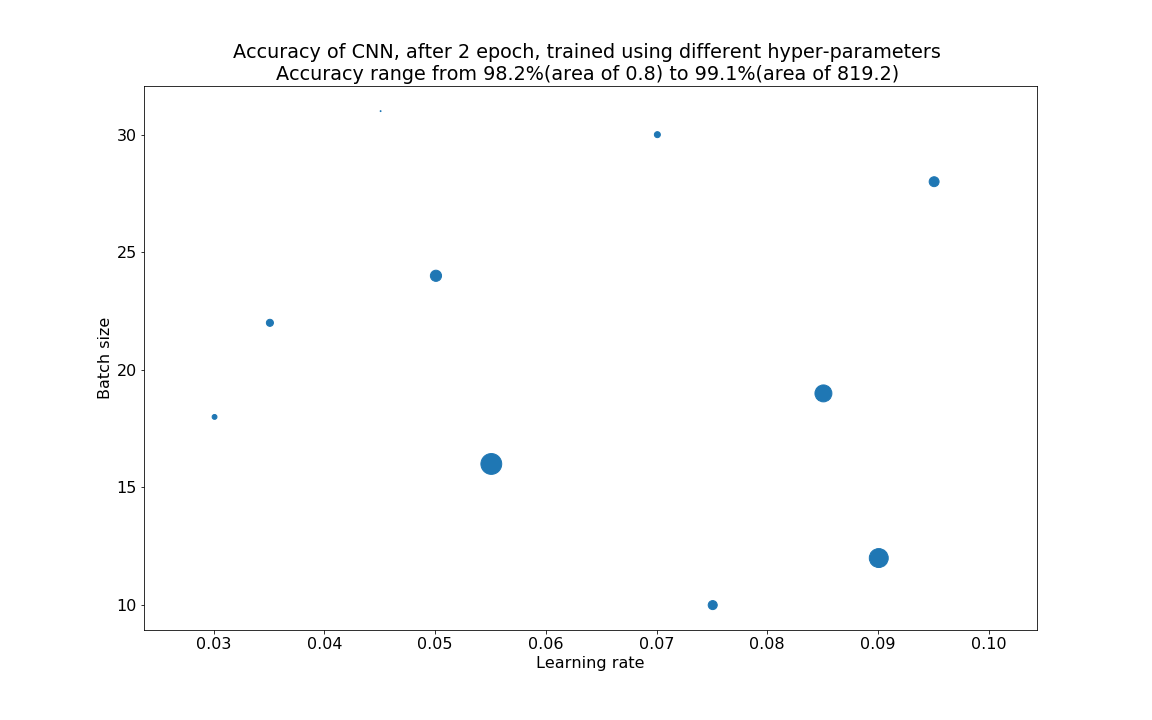

In [238]:
loading_path = "./output/2019February12_PM06H00M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

In [239]:
# define the loss function as the cross entropy and choose a learning rate that works well
criterion = nn.CrossEntropyLoss()
lr = 0.055
optimizer = optim.SGD(net_cnn.parameters(), lr=lr, momentum=0.0, weight_decay=0)
nb_epoch  = 10

training_batch_size = 1*16
train_loader = torch.utils.data.DataLoader(trainset, batch_size=training_batch_size,shuffle=True, num_workers=2)
cnn_state_dict_list = list()        # we save (all) the intermediate state of the model during the learning phase

# average loss across epoch
cnn_avg_loss     = torch.empty(nb_epoch  , dtype=torch.float, device = device)
# accuracy[i, 0 (resp. 1)] is the training (reps. validation) accuracy of the net at epoch i
cnn_accuracy     = torch.empty(nb_epoch,2, dtype=torch.float, device = device)

In [240]:
training_phase( net_cnn, nb_epoch, criterion, optimizer, cnn_avg_loss, cnn_accuracy, train_loader, cnn_state_dict_list )

epoch =   1, loss = 0.011494 , accuracy = 96.026665
epoch =   2, loss = 0.004409 , accuracy = 98.470001
epoch =   3, loss = 0.003220 , accuracy = 98.900002
epoch =   4, loss = 0.002335 , accuracy = 99.160004
epoch =   5, loss = 0.001839 , accuracy = 99.339996
epoch =   6, loss = 0.001404 , accuracy = 99.523331
epoch =   7, loss = 0.001252 , accuracy = 99.558334
epoch =   8, loss = 0.001220 , accuracy = 99.548332
epoch =   9, loss = 0.000883 , accuracy = 99.673332
epoch =  10, loss = 0.000645 , accuracy = 99.768333
Finished Training
Time required =  903.3673125  s 


#### Measure the accuracy of the net on the dataset(s) across epoch  
We retrieve every state dictionnary on the list, load it to the net  
and compute the accuracy on the chosen dataset(s).  

In [243]:
batch_size = 32*64
train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=False , num_workers=2)
valid_loader = torch.utils.data.DataLoader(testset , batch_size = batch_size, shuffle=False , num_workers=2)

measure_train_accuracy = False # this is already computed 
measure_valid_accuracy = True  # 

measure_accuracy( net_cnn , cnn_accuracy, train_loader, valid_loader, cnn_state_dict_list , 
                     measure_train_accuracy, measure_valid_accuracy )

epoch   1 : Accuracy of the network on the validation images: 98.55 % , training images 96.03 % 
epoch   2 : Accuracy of the network on the validation images: 98.76 % , training images 98.47 % 
epoch   3 : Accuracy of the network on the validation images: 98.69 % , training images 98.90 % 
epoch   4 : Accuracy of the network on the validation images: 98.83 % , training images 99.16 % 
epoch   5 : Accuracy of the network on the validation images: 98.91 % , training images 99.34 % 
epoch   6 : Accuracy of the network on the validation images: 99.07 % , training images 99.52 % 
epoch   7 : Accuracy of the network on the validation images: 99.02 % , training images 99.56 % 
epoch   8 : Accuracy of the network on the validation images: 98.96 % , training images 99.55 % 
epoch   9 : Accuracy of the network on the validation images: 99.00 % , training images 99.67 % 
epoch  10 : Accuracy of the network on the validation images: 98.66 % , training images 99.77 % 
Time required =  23.8906152343

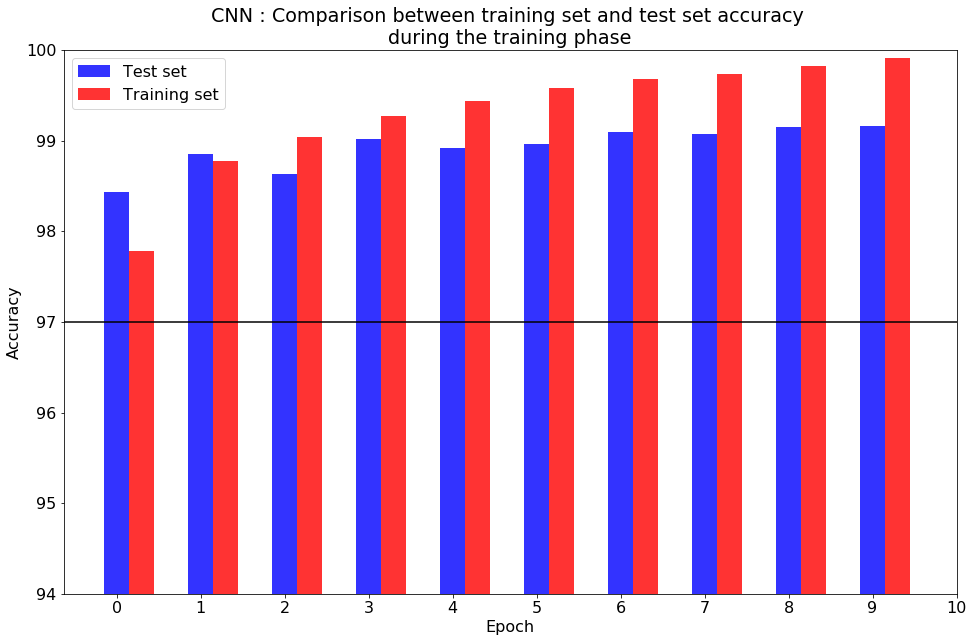

In [159]:
# Plot the accuracy
want_log     = False
path_to_save = "./output/" 
filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")
plot_accuracy_1d( net_cnn, lr, training_batch_size, cnn_accuracy, path_to_save, filename, "CNN : ", want_log )

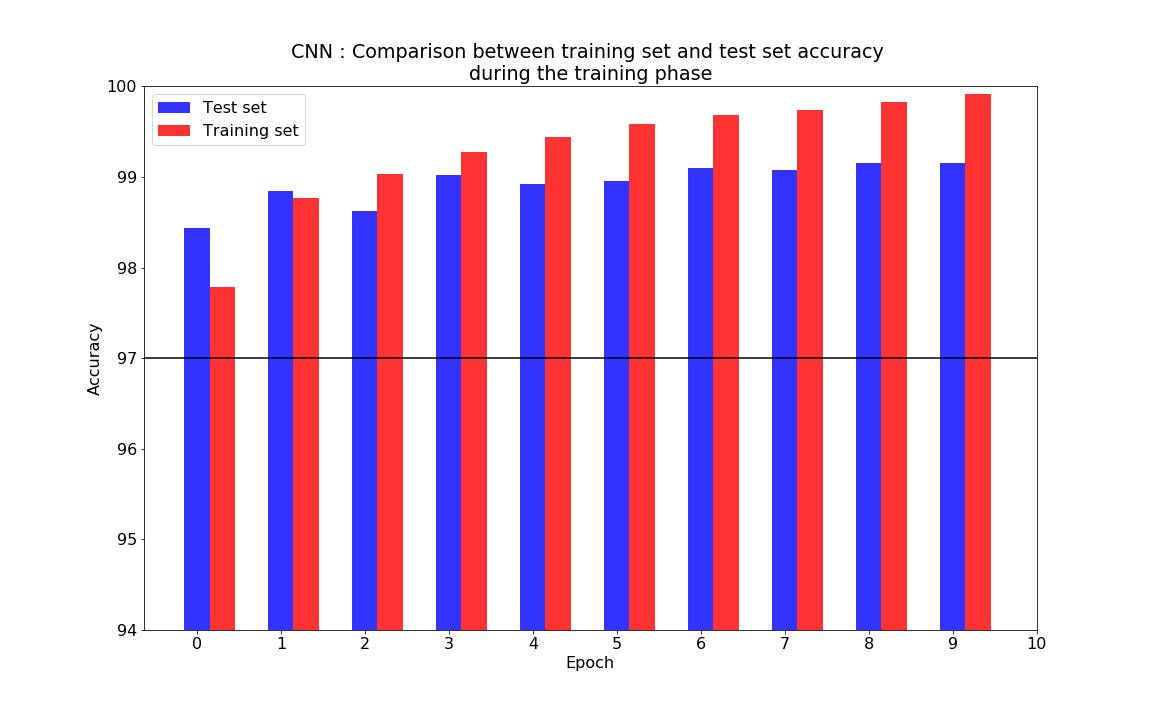

In [160]:
# Here's what we add when we runned the notebook :
loading_path = "./output/2019February12_PM03H48M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

# Train some multi-layer perceptron's (MLP's)

#### What we plan to do :  
a) We generate a pair (learning rate, batch size)  
b) We train an mlp for 3 epoch using these hyper-parameters  
c) We pick the mlp that has the highest accuracy on the validation dataset  
d) We train another mlp with the same hyper-parameters for 10 epoch  
e) We compare the performance of this mlp against the cnn  


Here's vizualisation of successive points from a 2d sobol sequence 

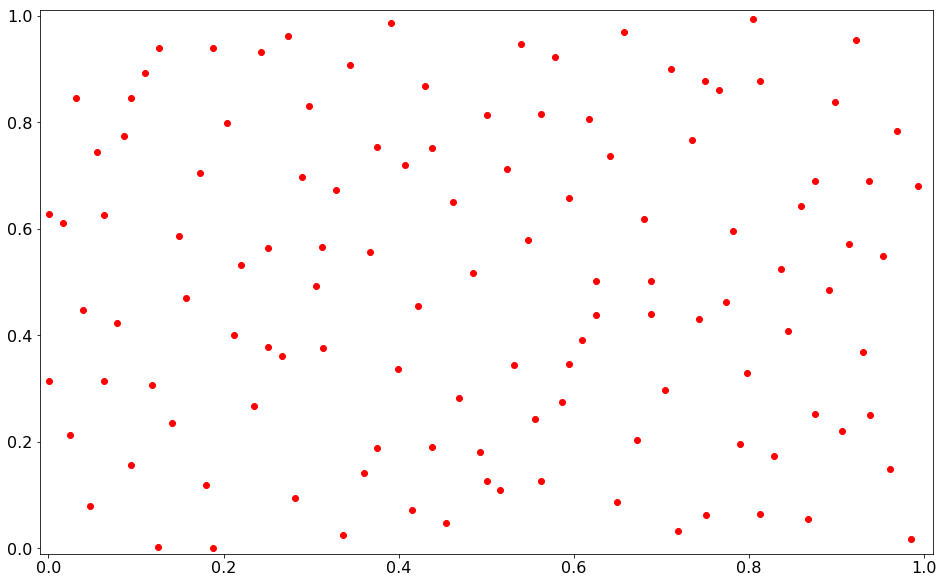

In [224]:
# Vizualize a sobol sequence
#seq = sobol_seq.i4_sobol_generate(2,32)
start     = 2030
nb_points = 120
seq = np.empty((nb_points,2))
end       = start + nb_points
for i,j in enumerate(range(start,end,1)) :
    seq[i,:] ,_ = sobol_seq.i4_sobol(2,j)

plt.plot(seq[:,0],seq[:,1], 'ro')
eps = 0.01
plt.axis([0 - eps , 1 + eps , 0 - eps , 1 + eps ])
plt.show()

In [225]:
nb_epoch  = 3

# current mlp with the best performance on the validation set, on its last epoch
acc_max = 0
idx_max = 0

# we save (all) the intermediate state of the model during the learning phase, for each mlp
state_dict_dict = dict() 

# search around a good learning rate : 0.055
lr_min = 0.02
lr_max = 0.10

# search around a good batch size : 2*8
batch_size_min =  1*8
batch_size_max =  6*8

#
valid_batch_size = 32*64
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=valid_batch_size,shuffle=False, num_workers=2)

# we started from 1030 for mlp and from 2030 for cnn
start     = 2030
nb_points = 12
valid_acc = torch.empty(nb_points)
seq = np.empty((nb_points,2))
end       = start + nb_points
for i,j in enumerate(range(start,end,1)) :   
    hyperparam_point ,_ = sobol_seq.i4_sobol(2,j)
    lr, batch_size      = hyperparam_point
    # take the point in the unitary cube and map it to the desired box
    lr         = lr*(lr_max-lr_min) +lr_min
    batch_size = math.ceil(batch_size*(batch_size_max-batch_size_min)+batch_size_min)
    
    if i != 0 :
        del net_mlp
        
    # net_mlp = MLP()
    net_mlp = CNNClassifier() # in order to search for good CNN parameters
    net_mlp.apply( glorot_init )
    _ = net_mlp.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net_mlp.parameters(), lr=lr, momentum=0.0, weight_decay=0)

    train_batch_size = batch_size
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,shuffle=True , num_workers=2)
    state_dict_list = list() # we save (all) the intermediate state of the model during the learning phase, for one  mlp

    # average loss across epoch
    avg_loss     = torch.empty(nb_epoch  , dtype=torch.float, device = device)
    # accuracy[i, 0 (resp. 1)] is the training (reps. validation) accuracy of the net at epoch i
    accuracy     = torch.empty(nb_epoch,2, dtype=torch.float, device = device)
    
    # print hyper-parameters 
    print("point no. {i}, lr = {lr}, batch size = {batch_size}".format(i=i+1, lr=lr,batch_size=batch_size))
    
    # we dump output to disable sound
    torch.cuda.synchronize()
    _ = training_phase( net_mlp, nb_epoch, criterion, optimizer, avg_loss, accuracy, train_loader, state_dict_list )
    state_dict_dict[i] = [[lr,batch_size],state_dict_list,avg_loss,accuracy]
    
    
    valid_accuracy = measure_single_accuracy(net_mlp,valid_loader)
    valid_acc[i] = valid_accuracy
    if valid_accuracy > acc_max :
        acc_max = valid_accuracy
        idx_max = i
    torch.cuda.synchronize()

print("#####################")
print("best net found : {i} , with validation accuracy = {va}".format(i=idx_max,va=acc_max.item()))
Audio(wave, rate=10000, autoplay=True)

point no. 1, lr = 0.0675390625, batch size = 22
epoch =   1, loss = 0.007640 , accuracy = 94.761665
epoch =   2, loss = 0.002303 , accuracy = 98.426666
epoch =   3, loss = 0.001627 , accuracy = 98.846664
Finished Training
Time required =  162.436171875  s 
point no. 2, lr = 0.0275390625, batch size = 42
epoch =   1, loss = 0.008117 , accuracy = 90.536667
epoch =   2, loss = 0.002267 , accuracy = 97.129997
epoch =   3, loss = 0.001595 , accuracy = 97.978333
Finished Training
Time required =  123.376  s 
point no. 3, lr = 0.0250390625, batch size = 21
epoch =   1, loss = 0.012179 , accuracy = 92.440002
epoch =   2, loss = 0.003556 , accuracy = 97.666664
epoch =   3, loss = 0.002504 , accuracy = 98.364998
Finished Training
Time required =  166.15309375  s 
point no. 4, lr = 0.0650390625, batch size = 41
epoch =   1, loss = 0.005508 , accuracy = 93.033333
epoch =   2, loss = 0.001596 , accuracy = 97.958336
epoch =   3, loss = 0.001093 , accuracy = 98.598335
Finished Training
Time required 

In [235]:

print(val)

[0.87727064 0.         0.26818052 0.6424236  1.         0.53636104
 0.82120836 0.769696   0.9515117  0.2621186  0.8181774  0.7772699 ]


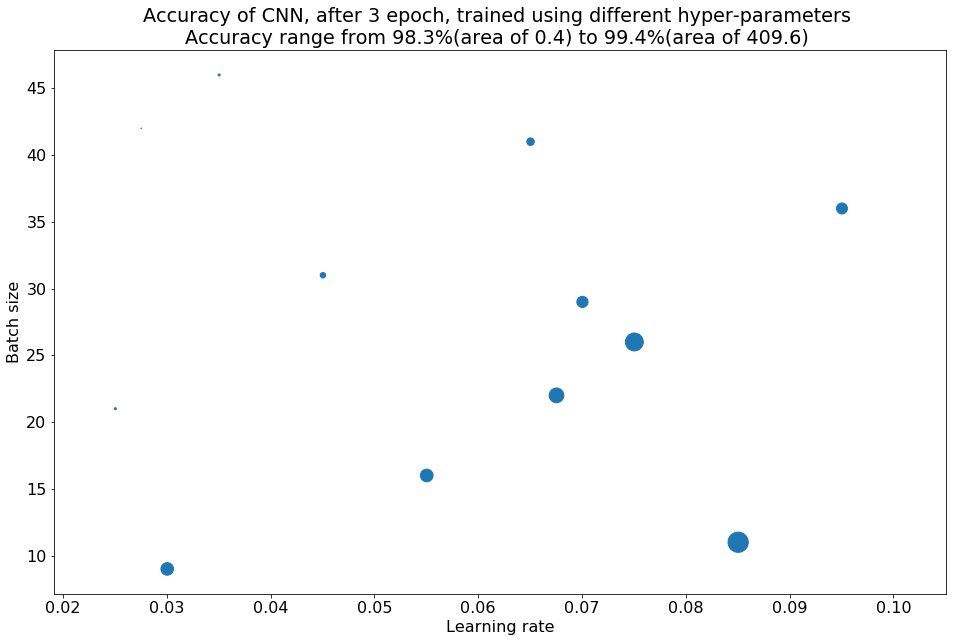

In [234]:
# taken from
# https://matplotlib.org/gallery/shapes_and_collections/scatter.html#sphx-glr-gallery-shapes-and-collections-scatter-py

# search around a good learning rate : 0.055
lr_min = 0.02
lr_max = 0.10

# search around a good batch size : 2*8
batch_size_min =  1*8
batch_size_max =  6*8

# Fixing start state for reproducibility
start     = 2030
nb_points = 12
end       = start + nb_points
_x = torch.empty(nb_points)
_y = torch.empty(nb_points) 
for i,j in enumerate(range(start,end,1)) :   
    hyperparam_point ,_ = sobol_seq.i4_sobol(2,j)
    lr, batch_size      = hyperparam_point
    # take the point in the unitary cube and map it to the desired box
    lr         = lr*(lr_max-lr_min) +lr_min
    batch_size = math.ceil(batch_size*(batch_size_max-batch_size_min)+batch_size_min)
    _x[i] = lr
    _y[i] = batch_size

N = nb_points
_val = valid_acc
val = _val.numpy()
val = val - val.min()
val = val / val.max() 
x = _x.numpy()
y = _y.numpy()
# colors = np.ones(N)*(0.2)
area = 0.4*(1+val)**10

str_title1 = "Accuracy of CNN, after {epoch} epoch, trained using different hyper-parameters \n".format(epoch=nb_epoch)
str_title2 = "Accuracy range from {min:.{prec}f}%(area of {rmin:.{prec}f}) to {max:.{prec}f}%(area of {rmax:.{prec}f}) ".format(
      min  = torch.min(valid_acc).item(),
      rmin = area.min(),
      max  = torch.max(valid_acc).item(),
      rmax = area.max(),
      prec = 1
    )
plt.title(str_title1+str_title2)
plt.xlabel('Learning rate')
plt.ylabel('Batch size')
    
plt.scatter(x, y, s=area)
want_log     = True
path_to_save = "./output/" 
filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")
if want_log :
        plt.savefig(path_to_save + filename + ".png")   
plt.show()

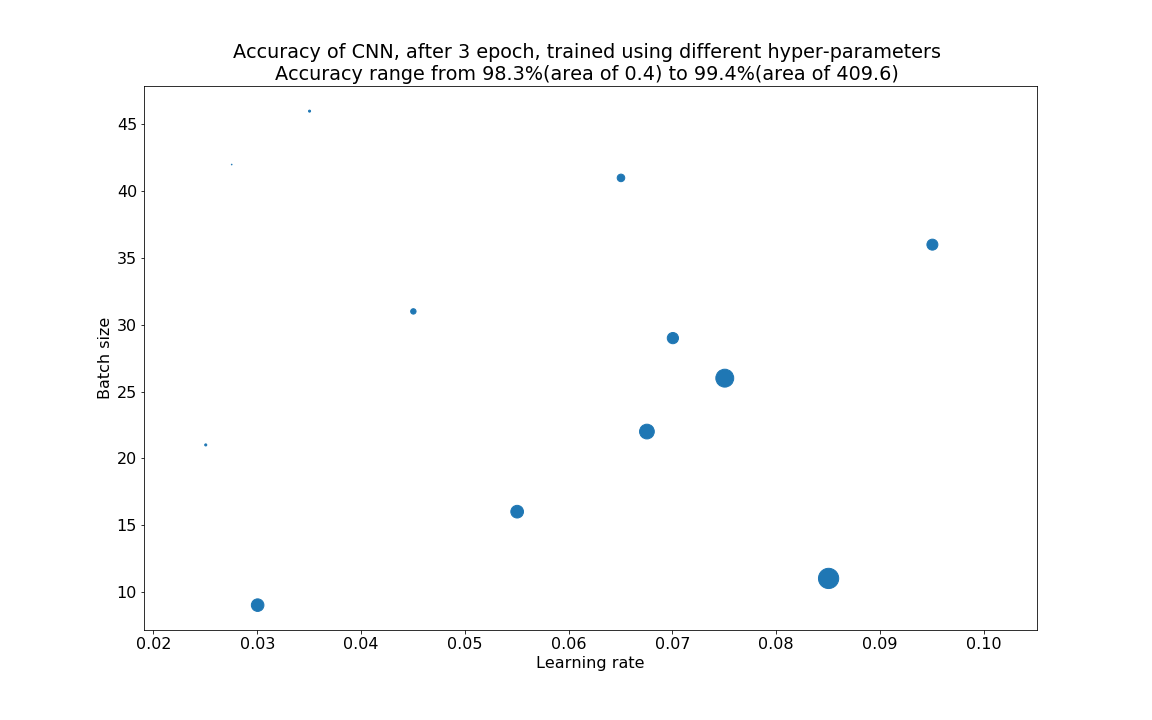

In [236]:
# Here's what we add when we runned the notebook :
loading_path = "./output/2019February12_PM03H07M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

### Take what seems to be the best choice of hyper-parameters and train an mlp  


#### Training

In [216]:
# retrieve the best performing mlp
# In our run, we got :
#                      - lr_mlp = 0.070 (learning rate)
#                      - bs_mlp = 15 (batch size)
#
(lr_mlp,bs_mlp),mlp_dict,mlp_avg_loss,mlp_accuracy = state_dict_dict[idx_max]
net_best_mlp = MLP()
# net_best_mlp.load_state_dict(mlp_dict[-1])
_ = net_best_mlp.to(device)

# 
nb_epoch  = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_best_mlp.parameters(), lr=lr_mlp, momentum=0.0, weight_decay=0)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=bs_mlp,shuffle=True, num_workers=2)
mlp_dict = list()
mlp_avg_loss     = torch.empty(nb_epoch  , dtype=torch.float, device = device)
mlp_accuracy     = torch.empty(nb_epoch,2, dtype=torch.float, device = device)
    
training_phase( net_best_mlp, nb_epoch, criterion, optimizer, mlp_avg_loss, mlp_accuracy, train_loader, mlp_dict )

epoch =   1, loss = 0.018487 , accuracy = 91.669998
epoch =   2, loss = 0.006390 , accuracy = 97.063332
epoch =   3, loss = 0.004207 , accuracy = 97.988335
epoch =   4, loss = 0.003030 , accuracy = 98.589996
epoch =   5, loss = 0.002128 , accuracy = 98.976669
epoch =   6, loss = 0.001586 , accuracy = 99.266670
epoch =   7, loss = 0.001137 , accuracy = 99.478333
epoch =   8, loss = 0.000924 , accuracy = 99.599998
epoch =   9, loss = 0.000631 , accuracy = 99.711670
epoch =  10, loss = 0.000407 , accuracy = 99.823334
Finished Training
Time required =  369.86321875  s 


#### Measure its accuracy

In [217]:
measure_train_accuracy = False # this is already computed 
measure_valid_accuracy = True  # 

batch_size = 16*64
valid_loader = torch.utils.data.DataLoader(testset , batch_size = batch_size, shuffle=False , num_workers=2)

measure_accuracy( net_best_mlp , mlp_accuracy, train_loader, valid_loader, mlp_dict , 
                     measure_train_accuracy, measure_valid_accuracy )

epoch   1 : Accuracy of the network on the validation images: 95.92 % , training images 91.67 % 
epoch   2 : Accuracy of the network on the validation images: 97.62 % , training images 97.06 % 
epoch   3 : Accuracy of the network on the validation images: 97.31 % , training images 97.99 % 
epoch   4 : Accuracy of the network on the validation images: 98.06 % , training images 98.59 % 
epoch   5 : Accuracy of the network on the validation images: 97.79 % , training images 98.98 % 
epoch   6 : Accuracy of the network on the validation images: 97.80 % , training images 99.27 % 
epoch   7 : Accuracy of the network on the validation images: 98.20 % , training images 99.48 % 
epoch   8 : Accuracy of the network on the validation images: 98.45 % , training images 99.60 % 
epoch   9 : Accuracy of the network on the validation images: 98.32 % , training images 99.71 % 
epoch  10 : Accuracy of the network on the validation images: 98.31 % , training images 99.82 % 
Time required =  12.8526494140

#### Plot the accuracy of mlp across epoch

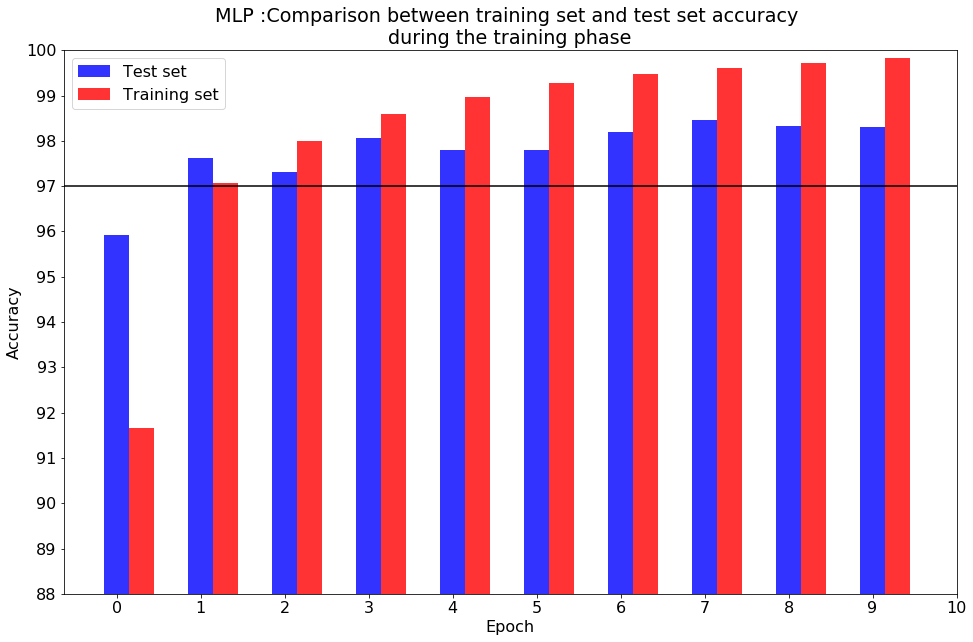

In [219]:
# Plot the accuracy
want_log     = False
path_to_save = "./output/" 
filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")
# plot_accuracy( mlp_accuracy, want_log , path_to_save, filename )
plot_accuracy_1d( net_best_mlp, lr_mlp, bs_mlp, mlp_accuracy, path_to_save, filename , "MLP :", want_log)

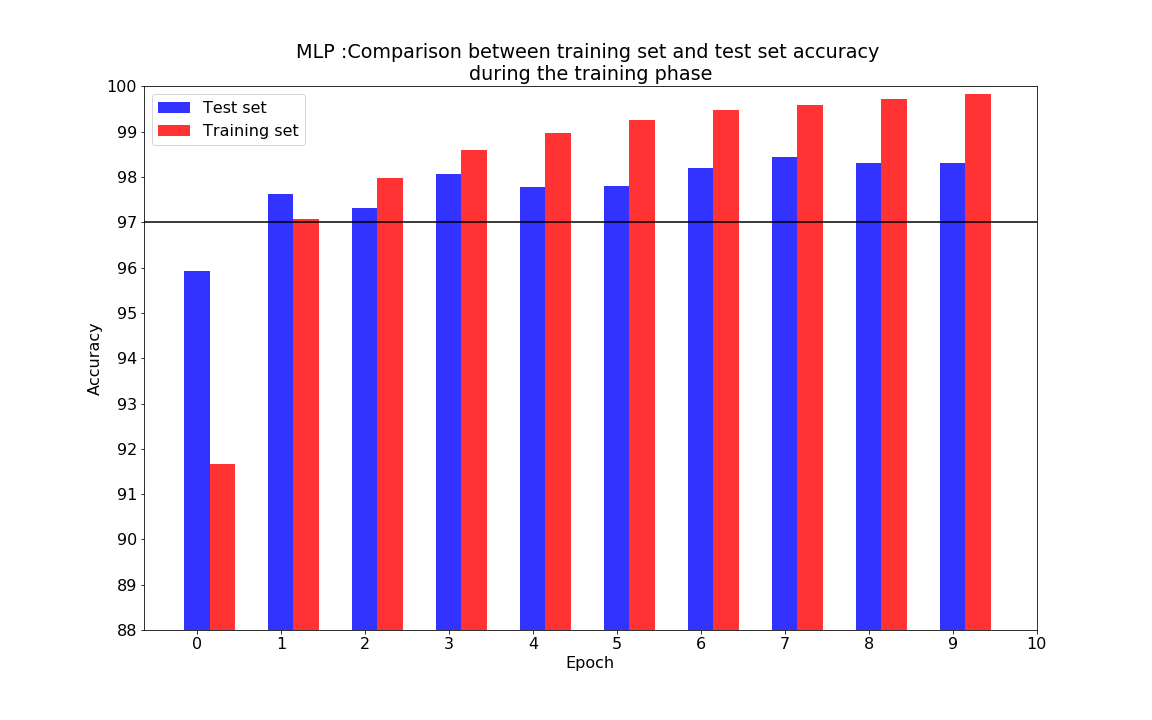

In [220]:
# Here's what we add when we runned the notebook :
loading_path = "./output/2019February12_PM05H12M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

### Compare the performance of the mlp and the cnn on both dataset  


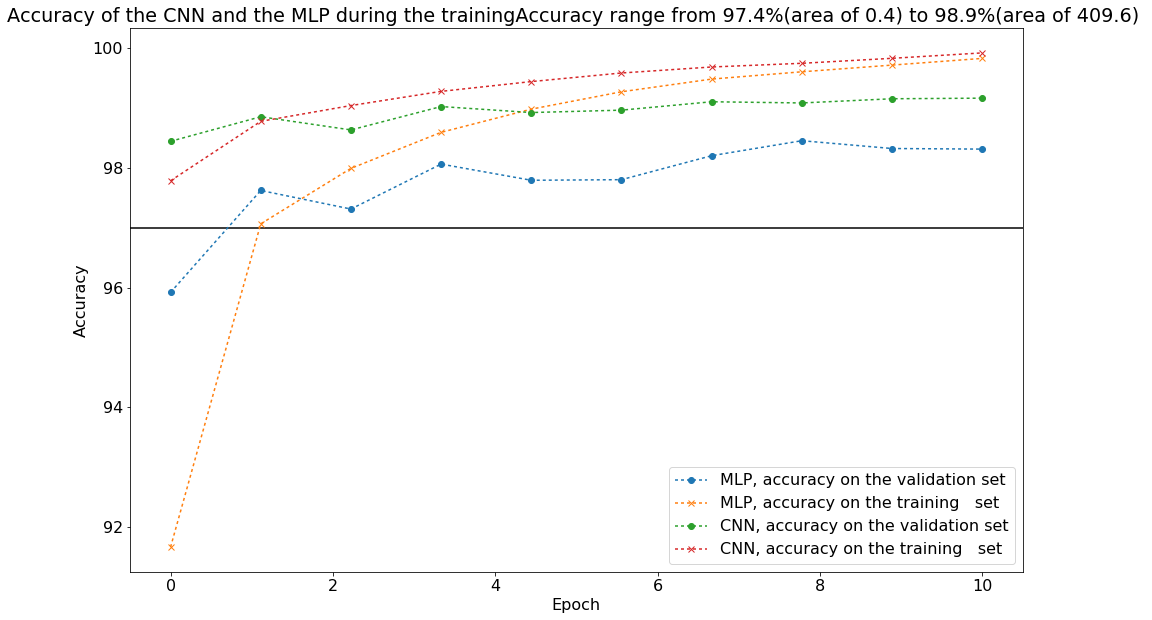

In [221]:
nb_epoch =  cnn_accuracy.size()[0]
x = np.linspace(0, nb_epoch, nb_epoch)
y1a = copy.deepcopy(mlp_accuracy[:,1]).cpu().numpy()
y1b = copy.deepcopy(mlp_accuracy[:,0]).cpu().numpy()
y2a = copy.deepcopy(cnn_accuracy[:,1]).cpu().numpy()
y2b = copy.deepcopy(cnn_accuracy[:,0]).cpu().numpy()

fig, ax = plt.subplots()

line1a_label = "MLP, accuracy on the validation set"
line1b_label = "MLP, accuracy on the training   set"
line2a_label = "CNN, accuracy on the validation set"
line2b_label = "CNN, accuracy on the training   set"

plt.axhline(y=97,color="black")

line1a, = ax.plot(x, y1a, "o-", label=line1a_label)
line1a.set_dashes([2, 2])  # 2pt line, 2pt break

line1b, = ax.plot(x, y1b, "x-", label=line1b_label)
line1b.set_dashes([2, 2])  # 2pt line, 2pt break

line2a, = ax.plot(x, y2a, "o-", label=line2a_label)
line2a.set_dashes([2, 2])  # 2pt line, 2pt break

line2b, = ax.plot(x, y2b, "x-", label=line2b_label)
line2b.set_dashes([2, 2])  # 2pt line, 2pt break

str_title1 = "Accuracy of the CNN and the MLP during the training"
plt.title(str_title1+str_title2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

ax.legend()
want_log     = False
path_to_save = "./output/" 
filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")
if want_log :
        plt.savefig(path_to_save + filename + ".png")   
plt.show()

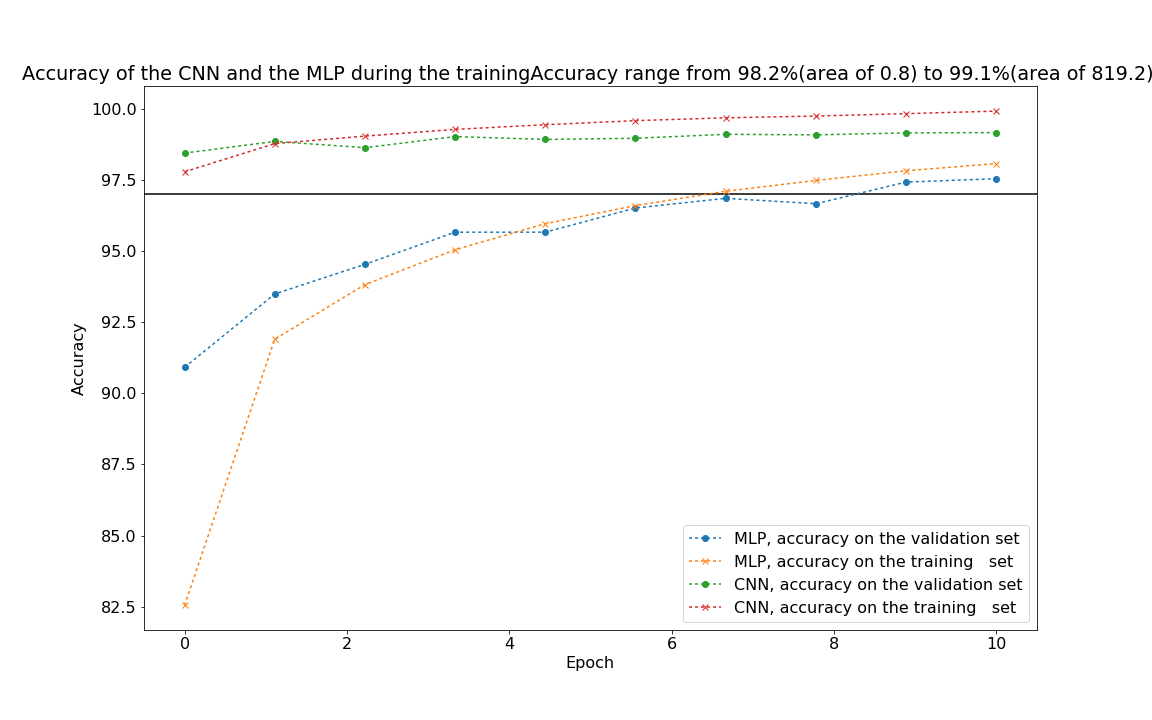

In [164]:
# Here's what we add when we runned the notebook :
loading_path = "./output/2019February12_PM03H53M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

## Some additionnal stuff

### Other comparison  

##### k-best Error : having the right label in the net's top k answers count as a good answer  
We measure errors

In [222]:
batch_size = 32*64
valid_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=True, num_workers=2)
net_list = [net_cnn,net_best_mlp]
acc      = np.empty(2)
for n,net in enumerate(net_list,0) :
    k = 1
    correct = torch.tensor([0], device=device)
    total   = torch.tensor([0], device=device)
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            predicted = torch.topk(outputs.data, k)[1]
            total += labels.size(0)
            for i in range(k) :
                correct += (predicted[:,i] == labels).sum()
        acc[n] = 100 - (100 * correct.double() / total.double()).item()

    print('{name} \n{k}-best Error of the network on the {nb} test images: {acc:.3f} %'.format(
                name= net.__doc__,
                k   = k,
                nb  = valid_dataset_size,
                acc = acc[n]
         ))
print("\n")
print("Relative difference = {diff:.2f} %".format( diff=100*abs(acc[0]-acc[1])/acc[0] ) )


    Convnet Classifier2, 3 conv layer, 2 fully connected layer
     
1-best Error of the network on the 10000 test images: 0.840 %

    MLP with 2 hidden layer
     
1-best Error of the network on the 10000 test images: 1.690 %


Relative difference = 101.19 %


# The interesting part of the notebook end here

#### print some test sample that the net misclassifies

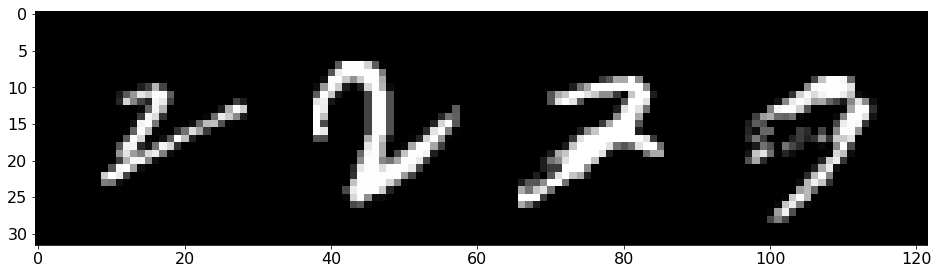

this should be :   2, 2, 2, 9
net choice # 1 :   8, 0, 7, 7
net choice # 2 :   2, 2, 2, 3
net choice # 3 :   3, 8, 3, 9


In [193]:
valid_loader  = torch.utils.data.DataLoader(testset , batch_size = 32*64, shuffle=True, num_workers=2)
net = net_cnn
nb_error = 4
nb_of_error = torch.tensor([nb_error])
j = torch.tensor([0])
errorimages  = torch.empty(nb_error,1,28,28)
errorlabels  = torch.empty(nb_error)
erroroutputs = torch.empty(nb_error, 10)
for images, labels in valid_loader :
    images, labels = images.to(device), labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    if not (predicted == labels).sum() == labels.size()[0] :
        comparison = (predicted == labels)
        for i,b in enumerate( comparison ) :
            if b == 0 :
                errorimages[j,:,:,:] = copy.deepcopy(images[i,:,:,:]).cpu()
                errorlabels[j] = labels[i].clone().detach().requires_grad_(False).cpu()
                erroroutputs[j,:] = outputs[i,:].clone().detach().requires_grad_(False).cpu()
                j = j + 1
                if j.item() >= nb_of_error.item() :
                    break
        else :
            continue
        break

if j.item() == 0 :
    print( "no error found")
else :
    imshow( torchvision.utils.make_grid(errorimages) )

    print( "this should be : " , ",".join( "%2d" % nb.item() for nb in errorlabels ) ) 
    for i in range(3) :
        print( "net choice #" , i+1 , ": " , ",".join( "%2d" % nb.item() for nb in list(torch.topk( erroroutputs, 3)[1][:,i]) ) ) 

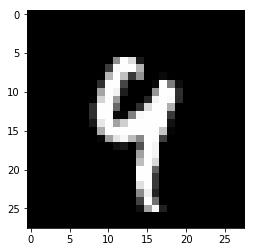

In [98]:
sample_image = errorimages[0]
imshow( torchvision.utils.make_grid(sample_image) )

In [77]:
net = copy.deepcopy(cudanet).cpu()

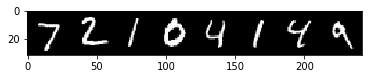

In [83]:
# get some random training images
valid_loader  = torch.utils.data.DataLoader(testset , batch_size = 8, shuffle=False, num_workers=2)
dataiter = iter(valid_loader)
images, labels = dataiter.next()
imshow( torchvision.utils.make_grid(images) )
sample_image = images[1]

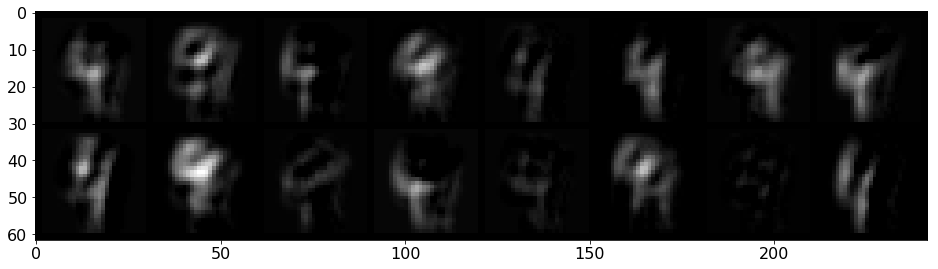

tensor(1.) tensor(0.)


In [215]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

layer = "1" # display all feature map of sample_image from layer
with torch.no_grad() :
    #print( net._modules )
    net.conv._modules[layer].register_forward_hook(get_activation(layer))
    output = net(sample_image.unsqueeze(0))

    act = activation[layer].squeeze().unsqueeze(1)
    # print(act.size())
    act = act - act.min()
    act = act / act.max() 
        
imshow(torchvision.utils.make_grid(act ))
print(act.max(),act.min())

tensor(1.) tensor(0.)


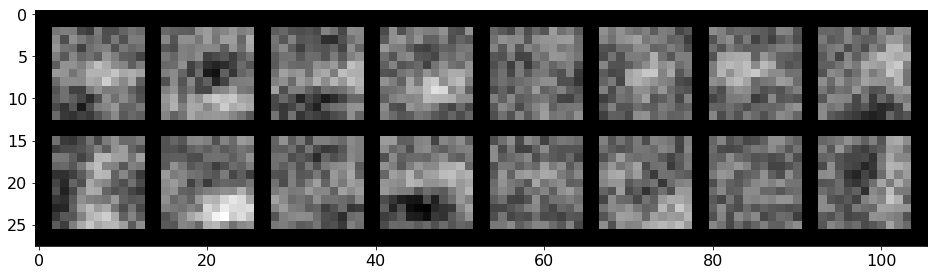

tensor(1.) tensor(0.)


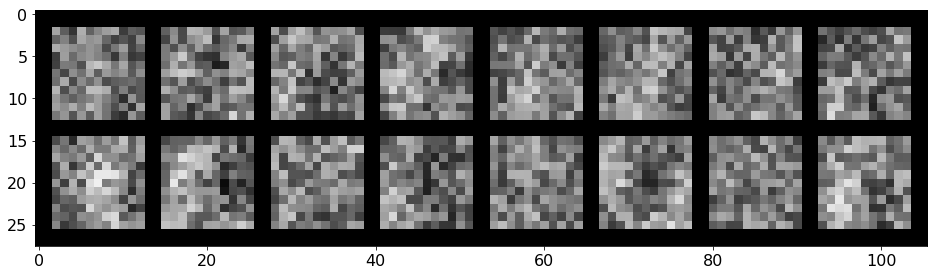

tensor(1.) tensor(0.)


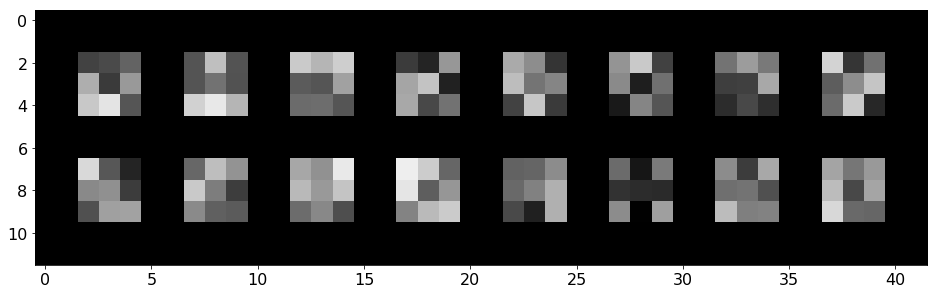

In [211]:
for i,(name, kernels) in enumerate(net.state_dict().items()) :
    if not (name.startswith("conv") and name.endswith("weight") ):
        continue 
    kernels = kernels.detach().view(-1,1,kernels.size()[-1],kernels.size()[-1])
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max() 
    size = min(kernels.size()[0],16)
    print( kernels.max() , kernels.min() )
    # print(kernels.size())
    imshow(torchvision.utils.make_grid(kernels[0:size,:,:,:]))

### Save and load models

#### Save the state_dict of the model for each epoch on a local directory

In [198]:
local_path = "./save"
for epoch , tmp_state_dict in enumerate(state_dict_list,1) :
    saving_path = local_path + "/dev1num2model_for_epoch{Epoch}.pth".format( Epoch = epoch )
    torch.save( tmp_state_dict , saving_path)

#### load from file and set the load the state_dict of the last epoch on a object
the files have to be located in "./save" and named "dev1num2model_for_epoch{j}.pth" for j from ... to ...

In [209]:
local_path = "./save"
state_dict_list = list()

from_idx = 1
to_idx = 10

for epoch in range( from_idx  , to_idx + 1 , 1 ):
    path = local_path + "/dev1num2model_for_epoch{Epoch}.pth".format( Epoch = epoch )
    tmp_dict = torch.load(path)
    state_dict_list.append(tmp_dict)
    print( path )
else : 
    cudanet = Classifier2()
    cudanet.load_state_dict(tmp_dict)
    cudanet.eval()                     

./save/dev1num2model_for_epoch1.pth
./save/dev1num2model_for_epoch2.pth
./save/dev1num2model_for_epoch3.pth
./save/dev1num2model_for_epoch4.pth
./save/dev1num2model_for_epoch5.pth
./save/dev1num2model_for_epoch6.pth
./save/dev1num2model_for_epoch7.pth
./save/dev1num2model_for_epoch8.pth
./save/dev1num2model_for_epoch9.pth
./save/dev1num2model_for_epoch10.pth


In [ ]:
class CNNClassifier2(nn.Module):
    """
    Convnet Classifier, 5 conv layer, 2 fully connected layer
    """
    def __init__(self, kernel_sz=11 , regression = 348, sigmoid=True ):
        
        self.sigmoid = sigmoid
        if kernel_sz % 2 == 0 :
            raise ValueError("kernel size must be odd")
        pad = kernel_sz // 2 
        
        super(CNNClassifier2, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1, input size = 28^2
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=( kernel_sz , kernel_sz ), padding=pad ),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 28^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=( kernel_sz , kernel_sz), padding=pad),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 28^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=( kernel_sz , kernel_sz), padding=pad),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4, input size = 14^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=( 3 , 3 ), padding = 0, stride = 3),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5, input size = 4^2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=( 2 , 2 ), padding = 0, stride = 2),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=(2, 2))
        )
        # Regression
        self.clf1 = nn.Linear(2*2*256, regression)
        self.clf2 = nn.Linear(regression, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0],-1)
        if self.sigmoid :
            x = torch.tanh(x)
        x = self.clf1(x)
        x = self.clf2(x)
        return x